In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection

## Correlation based

In [2]:
data_engineered = pd.read_csv('data/data_cleaned_engineered.csv')
data_engineered.set_index('PUF_ID', inplace=True)
data_engineered

,sample,fpl,FWBscore,FSscore,SUBKNOWL1,FINGOALS,SAVEHABIT,FRUGALITY,AUTOMATED_1,AUTOMATED_2,...,finalwt,SWB,ACT,PROPPLAN,MANAGE,MATHARDSHIP,FINSOC,MATERIALISM,SELFCONTROL,OUTLOOK
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,55.0,44.0,5.0,1.0,4.0,6.0,0.0,0.0,...,0.367292,5.0,4.0,4.0,4.0,1.0,6.0,4.0,3.0,2.0
7740,1,3,51.0,43.0,5.0,0.0,1.0,5.0,0.0,0.0,...,1.327561,6.0,4.0,2.0,3.0,1.0,1.0,3.0,3.0,4.0
13699,1,3,49.0,42.0,5.0,1.0,5.0,5.0,1.0,1.0,...,0.835156,4.0,3.0,4.0,3.0,1.0,2.0,4.0,3.0,4.0
7375,1,3,49.0,42.0,4.0,1.0,4.0,4.0,0.0,1.0,...,4.260668,4.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0
10910,1,3,67.0,57.0,6.0,1.0,4.0,5.0,1.0,1.0,...,0.760061,6.0,4.0,4.0,4.0,1.0,5.0,3.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,3,2,44.0,45.0,5.0,1.0,5.0,6.0,0.0,0.0,...,2.563018,7.0,4.0,4.0,4.0,1.0,7.0,2.0,3.0,3.0
11220,3,3,61.0,47.0,5.0,1.0,4.0,5.0,0.0,1.0,...,0.522504,7.0,4.0,3.0,4.0,1.0,3.0,3.0,3.0,4.0
8709,1,3,59.0,51.0,4.0,1.0,5.0,5.0,1.0,1.0,...,1.136270,6.0,4.0,4.0,5.0,1.0,3.0,4.0,2.0,4.0


In [3]:
cat_feats = ['sample', 'FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2',
             'HOUSING', 'LIVINGARRANGEMENT', 'SNAP', 'FRAUD2',
             'COVERCOSTS', 'MANAGE2', 'RETIRE', 'generation',
             'PPETHM', 'PPMARIT', 'PPREG9']

num_feats = list(set(data_engineered.columns) - set(cat_feats))

<Axes: >

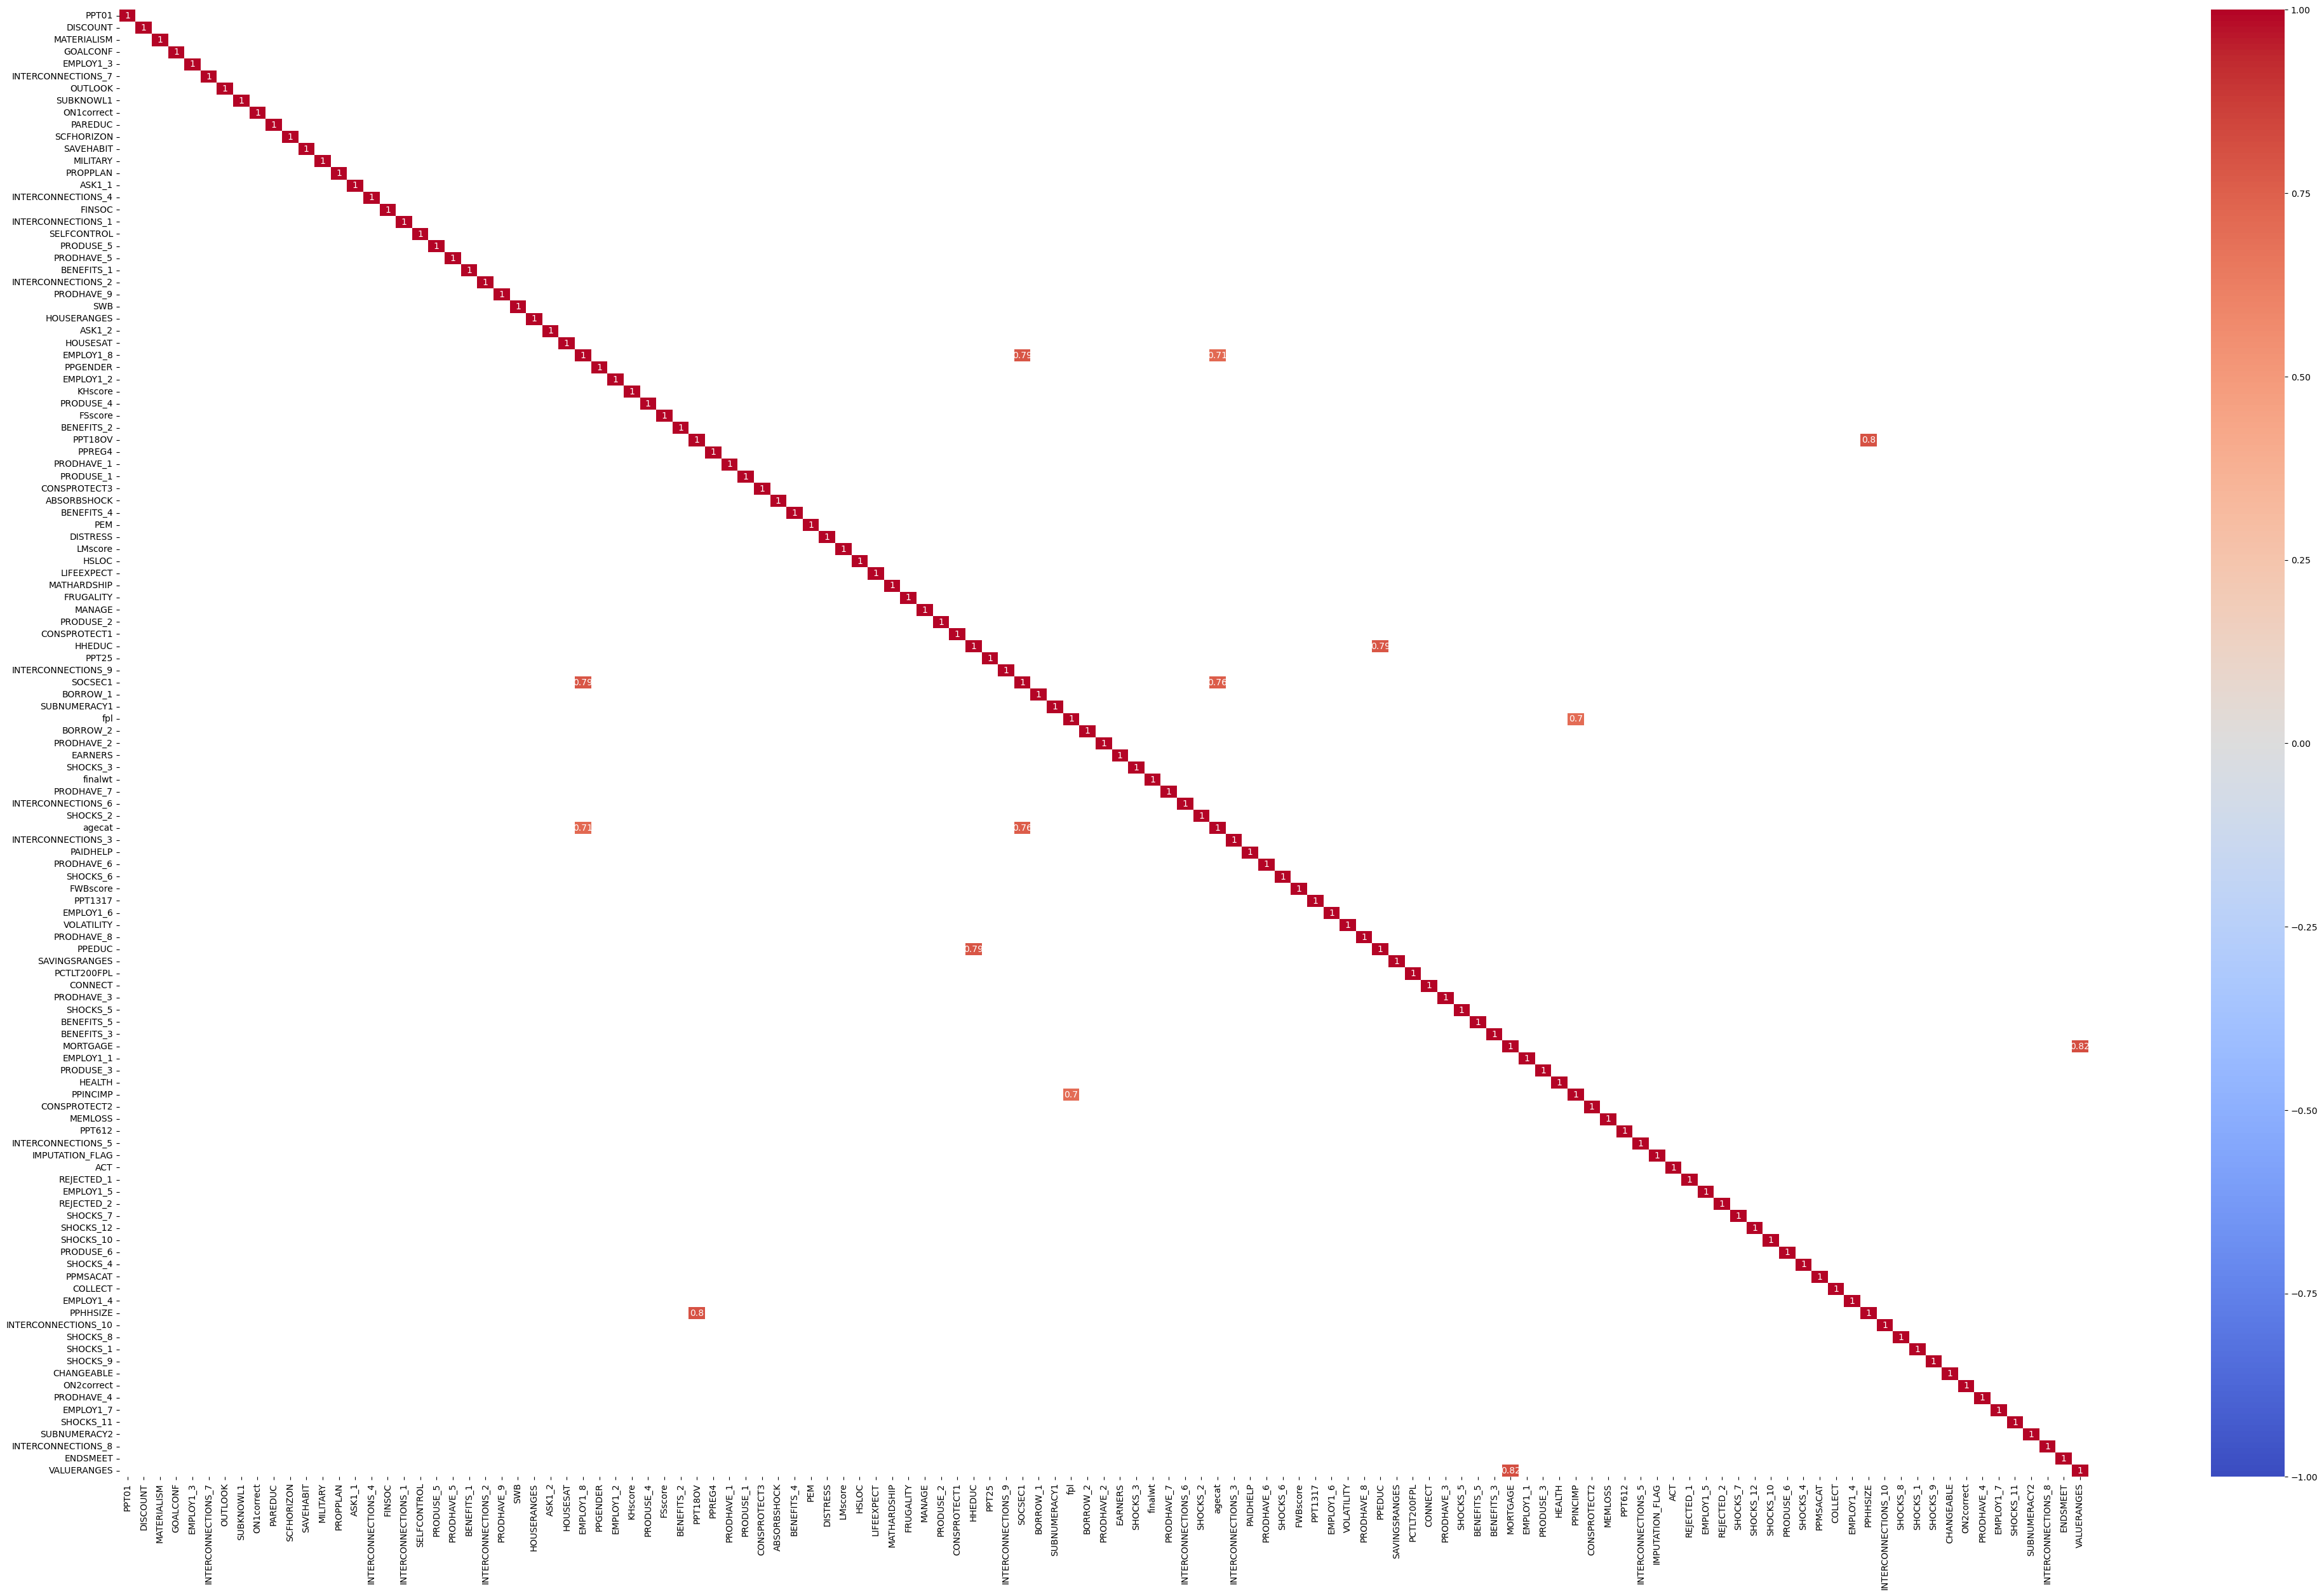

In [4]:
# sns heatmap with annot and only on one side of the diagonal and only on correlations above 0.7
plt.figure(figsize = (50, 30))
sns.heatmap(data_engineered[num_feats].corr(method = 'spearman')[data_engineered[num_feats].corr(method = 'spearman') > 0.7].dropna(how = 'all').dropna(how = 'all', axis = 1), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)

In [11]:
corr = data_engineered[num_feats].corr(method = 'spearman')
# get pivot table of correlations above 0.7 and below 1
corr[(corr > 0.7) & (corr < 1)].dropna(how = 'all').dropna(how = 'all', axis = 1)

,EMPLOY1_8,PPT18OV,HHEDUC,SOCSEC1,fpl,agecat,PPEDUC,MORTGAGE,PPINCIMP,PPHHSIZE,VALUERANGES
EMPLOY1_8,NaN,NaN,NaN,0.786994,NaN,0.713732,NaN,NaN,NaN,NaN,NaN
PPT18OV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.801902,NaN
HHEDUC,NaN,NaN,NaN,NaN,NaN,NaN,0.786872,NaN,NaN,NaN,NaN
SOCSEC1,0.786994,NaN,NaN,NaN,NaN,0.761934,NaN,NaN,NaN,NaN,NaN
fpl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.701187,NaN,NaN
agecat,0.713732,NaN,NaN,0.761934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PPEDUC,NaN,NaN,0.786872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MORTGAGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.819092
PPINCIMP,NaN,NaN,NaN,NaN,0.701187,NaN,NaN,NaN,NaN,NaN,NaN
PPHHSIZE,NaN,0.801902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# get pairs of features with correelation above 0.7
corr = data_engineered[num_feats].corr(method = 'spearman')
corr[corr > 0.7].notna().sum()[corr[corr > 0.7].notna().sum() > 1] # columns that are highly correlated with others

SOCSEC1        3
MORTGAGE       2
VALUERANGES    2
agecat         3
EMPLOY1_8      3
PPEDUC         2
PPHHSIZE       2
HHEDUC         2
fpl            2
PPT18OV        2
PPINCIMP       2
dtype: int64

Let's remove SOCSEC1 because it is highly correlated with both agecat and EMPLOY_8

VALUERANGES is HIGHLY correlated with MORTGAGE

In [43]:
data_engineered.corr(method = 'spearman')['MORTGAGE'].mean()

0.046711227015447

In [44]:
data_engineered.corr(method = 'spearman')['VALUERANGES'].mean()

0.05193523193114918

Let's remove VALUERANGES because ir has higher correlation with the overall variables

PPHHSIZE and PPT18OV are also highly correlated

Given we have variables PPT01 ... PPT1317, if all of them are set to 0 we know that there are no children. If there are no children, the variable PPT18OV and the variable PPHHSIZE are going to have the same value. Therefore, PPT18OV becomes useless. Let's remove it.

PPHEDUC and HHEDUC are also highly correlated. It is probably more important to know to level of education of the respondant rather than the highest level of education of all household members.

In [45]:
data_feat_selection = data_engineered.copy()

data_feat_selection.drop(['SOCSEC1', 'VALUERANGES', 'HHEDUC', 'PPT18OV'], axis = 1, inplace = True)

In [46]:
data_feat_selection.shape

(6078, 132)

In [47]:
data_feat_selection.to_csv('data/data_feat_selection.csv')

In [13]:
feat_sel = pd.read_csv('results/feat_sel/selected_features.csv')

In [21]:
feat_sel.drop('Unnamed: 0', axis = 1, inplace = True)

In [34]:
# get all columns which sum is above 5

feat_sel[(feat_sel.sum() > 6).index.values]

,sample,FWBscore,FSscore,SUBKNOWL1,FINGOALS,SAVEHABIT,FRUGALITY,AUTOMATED_1,AUTOMATED_2,ASK1_1,...,PCTLT200FPL,SWB,ACT,PROPPLAN,MANAGE,MATHARDSHIP,FINSOC,MATERIALISM,SELFCONTROL,OUTLOOK
0,1,1,1,1,1,1,1,1,0,1,...,1,1,0,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,1,1,1,1,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,0,1,1,0,1
4,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,0,1,1,0,1
5,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,0,0
6,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
7,1,1,1,1,1,1,1,1,0,1,...,0,1,1,1,1,1,1,1,0,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,0,0
9,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,0


In [43]:
feat_sel.sum()[feat_sel.sum() == 10].index

Index(['FWBscore', 'FSscore', 'SUBKNOWL1', 'SAVEHABIT', 'FRUGALITY',
       'AUTOMATED_1', 'CHANGEABLE', 'KHscore', 'HOUSERANGES', 'CONSPROTECT2',
       'SNAP', 'PAREDUC', 'CONNECT', 'HEALTH', 'HOUSESAT', 'LIFEEXPECT',
       'agecat', 'PPHHSIZE', 'PPINCIMP', 'PPREG9', 'PROPPLAN', 'FINSOC',
       'MATERIALISM'],
      dtype='object')